## **Store Sales - Time Series Forecasting**
*The object of this task is to predict the target sales for the dates, so the test csv doesn´t contain sales column.*

*The dates in the test data are for the 15 days after the last date in the training data.*

*Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.*

(1) IMPORT AND PROCESS THE DATA

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [123]:
train = pd.read_csv("data/store-sales/train.csv")
test = pd.read_csv("data/store-sales/test.csv")
holidays = pd.read_csv("data/store-sales/holidays_events.csv")
oil = pd.read_csv("data/store-sales/oil.csv")
stores = pd.read_csv("data/store-sales/stores.csv")
transactions = pd.read_csv("data/store-sales/transactions.csv")
submission = pd.read_csv("data/store-sales/submission.csv")

(2) TRAIN DATA

In [124]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [125]:
train.dtypes

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

In [126]:
train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [127]:
train.nunique()

id             3000888
date              1684
store_nbr           54
family              33
sales           379610
onpromotion        362
dtype: int64

There are 33 different family product types, so it's a good to look at all the different types and see which ones are selling the best.

<Axes: xlabel='family'>

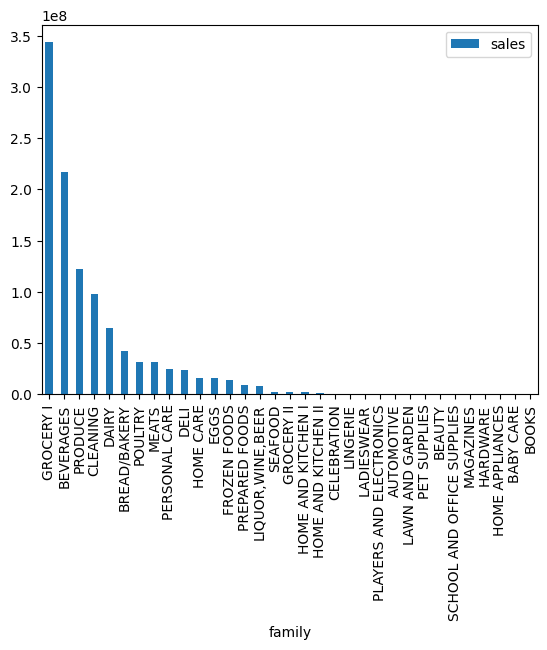

In [128]:
train[['family', 'sales']].groupby('family').sum().sort_values(by='sales', ascending=False).plot.bar()

(2.1) TRANSFORM THE DATE COLUMN INTO TIMESTAMP FORMAT

In [129]:
#1 --> Creating a new converted date column
train['date_dt'] = pd.to_datetime(train['date'] , errors = 'coerce') #if there is an error, Pandas will assign a NaT (Not a Time) value

In [130]:
#2 --> Creating a new date column converted to numeric format
train['date_num'] = train['date_dt'].dt.strftime("%Y%m%d").astype(int)

In [131]:
#3 --> Eliminating the original date columns
train.drop(columns=['date', 'date_dt'], axis=1, inplace=True)

In [132]:
train.head()

,id,store_nbr,family,sales,onpromotion,date_num
0,0,1,AUTOMOTIVE,0.0,0,20130101
1,1,1,BABY CARE,0.0,0,20130101
2,2,1,BEAUTY,0.0,0,20130101
3,3,1,BEVERAGES,0.0,0,20130101
4,4,1,BOOKS,0.0,0,20130101


(2.2) PREPARE TARGET DATA

In [133]:
y = train['sales'] #variable to predict
train.drop(columns= ['sales'], inplace=True, axis=1)

(3) TEST DATA

In [134]:
test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [135]:
test.dtypes

id              int64
date           object
store_nbr       int64
family         object
onpromotion     int64
dtype: object

In [136]:
test.isnull().sum()

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

In [137]:
test.nunique()

id             28512
date              16
store_nbr         54
family            33
onpromotion      212
dtype: int64

(2.1) TRANSFORM THE DATE COLUMN INTO TIMESTAMP FORMAT

In [138]:
test['date_dt'] = pd.to_datetime(test['date'] , errors = 'coerce')
test['date_num'] = test['date_dt'].dt.strftime("%Y%m%d").astype(int)
test.drop(columns=['date', 'date_dt'], axis=1, inplace=True)

(3) A CALENDAR IS NECESSARY BECAUSE MANY DATA ARE MISSING DAYS, ESPECIALLY IN OIL PRICE

In [139]:
data = pd.date_range('2013-01-01', '2017-08-31') #define the date range
calendar = pd.DataFrame(data,columns=['date']) #insert the data
calendar

,date
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05
...,...
1699,2017-08-27
1700,2017-08-28
1701,2017-08-29
1702,2017-08-30


(4) OIL PRICE IS AN IMPORTANT VARIABLE FOR ANALYSIS DUE TO ITS IMPACT ON THE COUNTRY'S ECONOMY

In [140]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


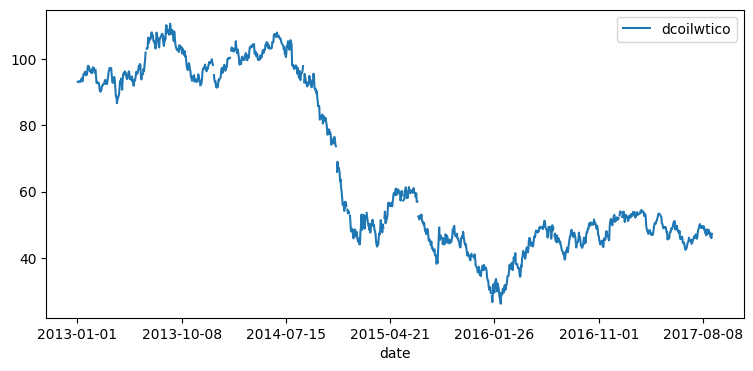

In [141]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9,4)) #create figure + axes
oil.plot.line(x="date", y="dcoilwtico", ax=axes) #draw the line on the specified set of axes
plt.show()

*THERE ARE MISSING VALUES, FOR EXAMPLE IN 2015*

In [142]:
#transform date column
oil['date'] = pd.to_datetime(oil['date'], errors = 'coerce')

#merge calendar and oil tables
calendar2 = pd.merge(calendar, oil, how='left', on='date')

#fill null values with forward fill method
calendar2['dcoilwtico'].ffill(inplace=True)

In [143]:
oil.isnull().sum()

date           0
dcoilwtico    43
dtype: int64

In [144]:
oil.head() #the first value is null so it will be necessary to use backward fill method

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [145]:
calendar2['dcoilwtico'].bfill(inplace=True)

In [146]:
calendar2.head()
calendar2.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

(5) HOLIDAY DATA IS ALSO VERY IMPORTANT BECAUSE SALES TEND TO BE HIGHER ON THESE DAYS

In [147]:
transferred_data = holidays[holidays['type'] == 'Transfer']
transferred_data

,date,type,locale,locale_name,description,transferred
20,2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
73,2013-10-11,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
136,2014-10-10,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
256,2016-05-27,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
265,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False
269,2016-08-12,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False
298,2017-01-02,Transfer,National,Ecuador,Traslado Primer dia del ano,False
304,2017-04-13,Transfer,Local,Cuenca,Fundacion de Cuenca,False
313,2017-05-26,Transfer,National,Ecuador,Traslado Batalla de Pichincha,False
325,2017-08-11,Transfer,National,Ecuador,Traslado Primer Grito de Independencia,False


There are some data that has been moved by the government

In [148]:
#new column with the day of the week
calendar2['day_week'] = calendar['date'].dt.dayofweek # 0 Monday, 6 Sunday

#new column to find out if it is a weekday or holiday
calendar2['holiday_or_weekday'] = 'weekday'

#Using the loc function, rows are selected where the value in the 'day_week' column is greater than 4 (Saturday or Sunday).
#For these selected rows, the value in the 'holiday_or_weekday' column is updated to 'holiday'.
calendar2.loc[calendar2['day_week'] > 4, 'holiday_or_weekday'] = 'holiday'

holidays = holidays.drop_duplicates(subset=['date'])

calendar2.head()

,date,dcoilwtico,day_week,holiday_or_weekday
0,2013-01-01,93.14,1,weekday
1,2013-01-02,93.14,2,weekday
2,2013-01-03,92.97,3,weekday
3,2013-01-04,93.12,4,weekday
4,2013-01-05,93.12,5,holiday


In [149]:
holidays['date'] = pd.to_datetime(holidays['date'], errors = 'coerce') #change the type to merge with calendar2

calendar2 = pd.merge(calendar2, holidays, how='left', on='date')
calendar2.head()

,date,dcoilwtico,day_week,holiday_or_weekday,type,locale,locale_name,description,transferred
0,2013-01-01,93.14,1,weekday,Holiday,National,Ecuador,Primer dia del ano,False
1,2013-01-02,93.14,2,weekday,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,92.97,3,weekday,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,93.12,4,weekday,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,93.12,5,holiday,Work Day,National,Ecuador,Recupero puente Navidad,False


In [150]:
calendar2['type'].unique()

array(['Holiday', nan, 'Work Day', 'Additional', 'Transfer', 'Event',
       'Bridge'], dtype=object)

changing certain values for clarity

In [151]:
calendar2.loc[calendar2.type == 'Bridge'  , 'holiday_or_weekday'] = 'holiday'
calendar2.loc[calendar2.type == 'Transfer', 'holiday_or_weekday'] = 'holiday'
calendar2.loc[calendar2.type == 'Work Day', 'holiday_or_weekday'] = 'weekday'

calendar2.loc[(calendar2.type == 'Holiday') & (calendar2.transferred == False), 'holiday_or_weekday'] = 'holiday'
calendar2.loc[(calendar2.type == 'Holiday') & (calendar2.transferred == True ), 'holiday_or_weekday'] = 'weekday'

In [152]:
calendar2['holiday_or_weekday'].unique()

array(['holiday', 'weekday'], dtype=object)

In [153]:
calendar2 = calendar2[['date', 'dcoilwtico', 'day_week', 'holiday_or_weekday']]
calendar2.head()

,date,dcoilwtico,day_week,holiday_or_weekday
0,2013-01-01,93.14,1,holiday
1,2013-01-02,93.14,2,weekday
2,2013-01-03,92.97,3,weekday
3,2013-01-04,93.12,4,weekday
4,2013-01-05,93.12,5,weekday


In [154]:
calendar2.dtypes

date                  datetime64[ns]
dcoilwtico                   float64
day_week                       int32
holiday_or_weekday            object
dtype: object

In [155]:
calendar2['date_num'] = calendar2['date'].dt.strftime("%Y%m%d").astype(int)
calendar2.drop(columns = ['date'] , axis = 1 , inplace = True)

In [156]:
calendar2.head()
#calendar2.dtypes

,dcoilwtico,day_week,holiday_or_weekday,date_num
0,93.14,1,holiday,20130101
1,93.14,2,weekday,20130102
2,92.97,3,weekday,20130103
3,93.12,4,weekday,20130104
4,93.12,5,weekday,20130105


PREPARATION PRIOR TO FORECASTING

In [157]:
train = pd.merge(train, calendar2, how='left', on='date_num')
test = pd.merge(test, calendar2, how='left', on='date_num')

In [158]:
#its not necessary the column onpromotion
train.drop(columns=['onpromotion'], axis=1, inplace=True)
test.drop(columns=['onpromotion'], axis=1, inplace=True)

In [159]:
train.head()

,id,store_nbr,family,date_num,dcoilwtico,day_week,holiday_or_weekday
0,0,1,AUTOMOTIVE,20130101,93.14,1,holiday
1,1,1,BABY CARE,20130101,93.14,1,holiday
2,2,1,BEAUTY,20130101,93.14,1,holiday
3,3,1,BEVERAGES,20130101,93.14,1,holiday
4,4,1,BOOKS,20130101,93.14,1,holiday


Family and Holiday_or_weekday, have to be of numeric type, in order to apply Machine Learning

In [160]:
#import LabelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

In [161]:
#transform family and holiday_or_weekday
train['family'] = le.fit_transform(train['family'])
test['family'] = le.fit_transform(test['family'])

train['holiday_or_weekday'] = le.fit_transform(train['holiday_or_weekday'])
test['holiday_or_weekday'] = le.fit_transform(test['holiday_or_weekday'])

In [162]:
train['family'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

In [163]:
train.drop(columns=['id'], axis=1, inplace=True)
test.drop(columns=['id'], axis=1, inplace=True)

In [164]:
print(train.shape)
print(y.shape)
print()
print(test.shape)

(3000888, 6)
(3000888,)

(28512, 6)


ITS TIME TO USE THE DATA CREATED TO TRAIN THE MODEL

In [165]:
train.head()

,store_nbr,family,date_num,dcoilwtico,day_week,holiday_or_weekday
0,1,0,20130101,93.14,1,0
1,1,1,20130101,93.14,1,0
2,1,2,20130101,93.14,1,0
3,1,3,20130101,93.14,1,0
4,1,4,20130101,93.14,1,0


In [166]:
y

0             0.000
1             0.000
2             0.000
3             0.000
4             0.000
             ...   
3000883     438.133
3000884     154.553
3000885    2419.729
3000886     121.000
3000887      16.000
Name: sales, Length: 3000888, dtype: float64

In [167]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(train, y) #train (characteristics) and y (labels or target values, sales in this case)

lr

LinearRegression()

In [168]:
print(lr.coef_) #attribute that stores the estimated coefficients (or slopes) for each feature in the data set
print()
print(lr.intercept_) #is the point on the y-axis where the regression line intersects the x-axis
#it represents the predicted value when all characteristics are zero

[ 2.91277929e+00 -1.32119645e+01  5.26950544e-03 -8.96568230e-01
  5.51432650e+00 -9.26842345e+01]

-105581.86061371662


**Expected sales is the result of multiplying each column by the estimated coefficient, adding the sum of the intercept**

In [169]:
train['linear_predictions'] = lr.predict(train)
train

,store_nbr,family,date_num,dcoilwtico,day_week,holiday_or_weekday,linear_predictions
0,1,0,20130101,93.14,1,0,418.736938
1,1,1,20130101,93.14,1,0,405.524973
2,1,2,20130101,93.14,1,0,392.313009
3,1,3,20130101,93.14,1,0,379.101044
4,1,4,20130101,93.14,1,0,365.889080
...,...,...,...,...,...,...,...
3000883,9,28,20170815,47.57,1,0,327.503425
3000884,9,29,20170815,47.57,1,0,314.291461
3000885,9,30,20170815,47.57,1,0,301.079496
3000886,9,31,20170815,47.57,1,0,287.867532


In [170]:
from sklearn.metrics import mean_absolute_error

#the distance between the sales and my predicted sales
mean_absolute_error(y, train['linear_predictions'])

498.6781237925033

*On Average were off by 498*

**PREDICT SALES FROM THE TEST DATA SET**

In [171]:
test.head()

,store_nbr,family,date_num,dcoilwtico,day_week,holiday_or_weekday
0,1,0,20170816,46.8,2,1
1,1,1,20170816,46.8,2,1
2,1,2,20170816,46.8,2,1
3,1,3,20170816,46.8,2,1
4,1,4,20170816,46.8,2,1


In [172]:
test['Sales'] = lr.predict(test) #lr is the previously trained linear regression model
test

,store_nbr,family,date_num,dcoilwtico,day_week,holiday_or_weekday,Sales
0,1,0,20170816,46.80,2,1,587.661916
1,1,1,20170816,46.80,2,1,574.449951
2,1,2,20170816,46.80,2,1,561.237987
3,1,3,20170816,46.80,2,1,548.026022
4,1,4,20170816,46.80,2,1,534.814058
...,...,...,...,...,...,...,...
28507,9,28,20170831,47.26,3,1,246.210092
28508,9,29,20170831,47.26,3,1,232.998127
28509,9,30,20170831,47.26,3,1,219.786163
28510,9,31,20170831,47.26,3,1,206.574198


In [173]:
submission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [175]:
submission['sales'] = test['Sales']

In [176]:
submission.head()

,id,sales
0,3000888,587.661916
1,3000889,574.449951
2,3000890,561.237987
3,3000891,548.026022
4,3000892,534.814058


In [177]:
submission.to_csv('final_prediction.csv', index=False)

USING RANDOM FOREST REGRESSOR

In [ ]:
#importing the random forest regression model
from sklearn.ensemble import RandomForestRegressor

#n_estimators = the number of trees in the forest (in this case, it is set at 30)
#n_jobs = the number of workers to fit the trees in parallel (-1 indicates that all available processors should be used)
#random_state = seed for reproducibility
rf = RandomForestRegressor(n_estimators = 30, n_jobs=-1, random_state=1)

rf.fit(train , y)

pre = rf.predict(test)

submission['sales'] = pre